## Target Maximization

This section covers budget optimization by maximizing target with the insights from a fitted MMM.

In [11]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import pickle

from karpiu.planning.optim import TargetMaximizer
from karpiu.planning.common import generate_cost_report
from karpiu.plots import ColorConstants

pd.set_option("display.float_format", lambda x: "%.5f" % x)
np.set_printoptions(suppress=True)
pd.set_option("display.max_rows", 50)

In [2]:
%load_ext autoreload
%autoreload 2

Bring back the fitted model from previous `Quickstart` section.

In [3]:
with open("./resource/seasonal/model.pkl", "rb") as f:
    mmm = pickle.load(f)

In [5]:
budget_start = pd.to_datetime("2021-01-01")
budget_end = pd.to_datetime("2021-01-31")
optim_channels = mmm.get_spend_cols()

In [25]:
maximizer = TargetMaximizer(
    model=mmm,
    budget_start=budget_start,
    budget_end=budget_end,
    optim_channels=optim_channels,
    variance_penalty=0.0,
    # response_scaler=10.0,
)
optim_spend_df = maximizer.optimize(maxiter=5000)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -48512.127981759746
            Iterations: 1111
            Function evaluations: 173628
            Gradient evaluations: 1109


In [26]:
optim_spend_matrix = maximizer.get_current_state()
init_spend_matrix = maximizer.get_init_state()

In [27]:
# total spend suggest
print("Suggested total spend: {:.0f}".format(np.sum(optim_spend_matrix)))
# total budget
print("Total Budget: {:.0f}".format(np.sum(init_spend_matrix)))

Suggested total spend: 453606
Total Budget: 453606


### Budget Allocation

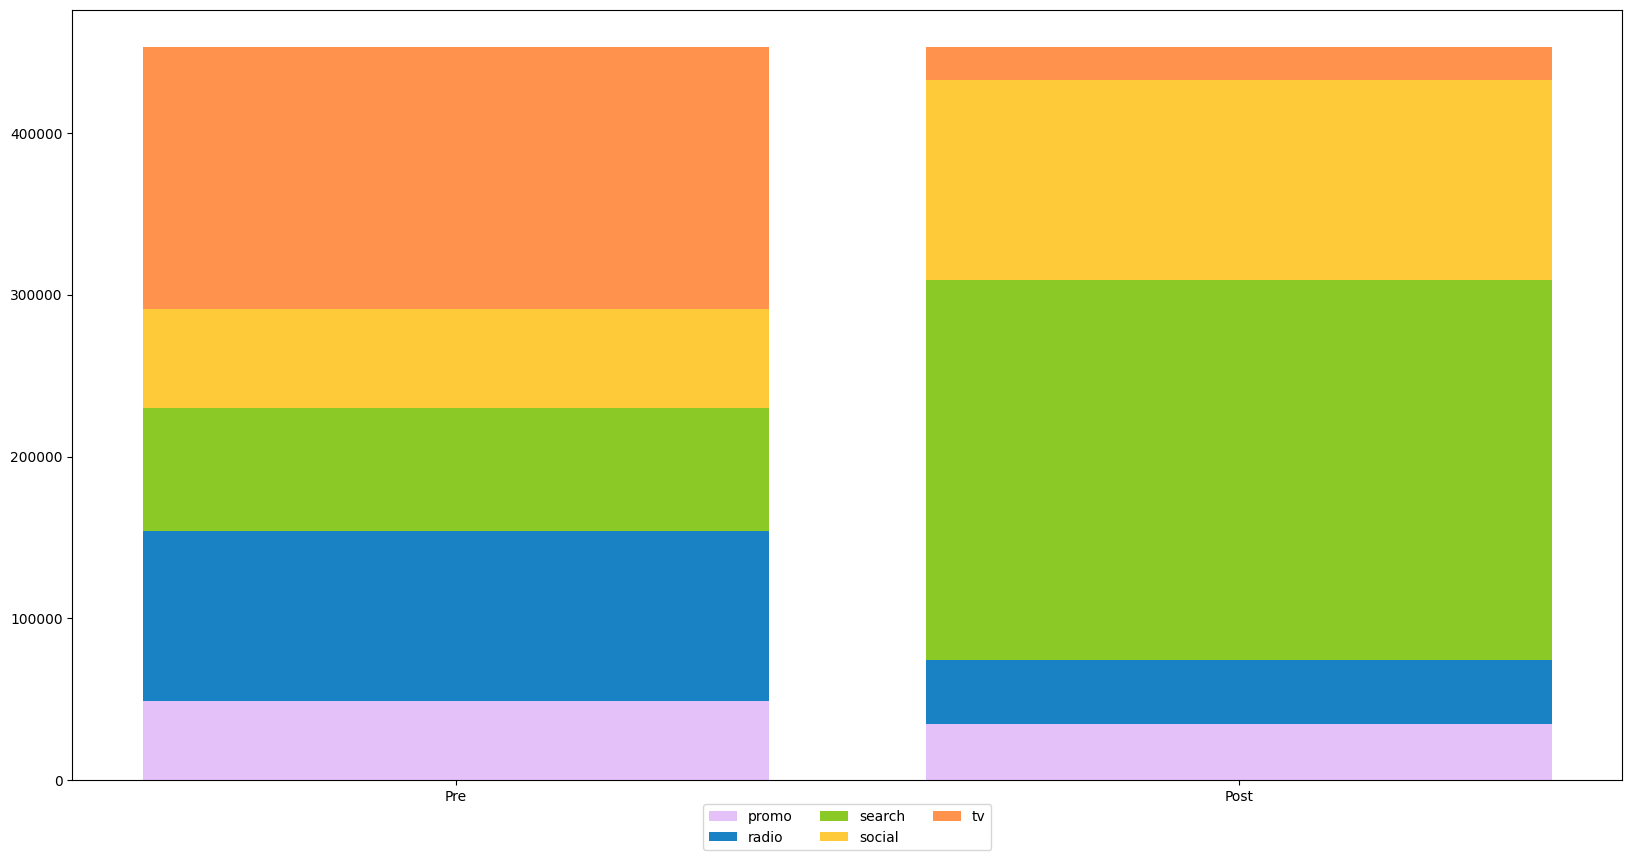

In [28]:
init_total_spend = np.sum(init_spend_matrix, 0)
optim_total_spend = np.sum(optim_spend_matrix, 0)
plot_data = np.vstack([init_total_spend, optim_total_spend])
plot_data.shape

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
bottom = 0.0
for idx, label in enumerate(optim_channels):
    ax.bar(x=["Pre", "Post"], height=plot_data[:, idx], bottom=bottom, label=label, color=ColorConstants.RAINBOW_SIX[idx])
    bottom += plot_data[:, idx]
# ax.set_title("Spend Allocation Pre vs. Post Optimization")
ax.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.10),
    ncol=math.ceil(len(optim_channels) / 2),
);

### Average and Marginal Cost Change

In [29]:
df = mmm.get_raw_df()

In [58]:
cost_report = generate_cost_report(
    model=mmm,
    channels=optim_channels,
    start=budget_start,
    end=budget_end,
    pre_spend_df=df,
    post_spend_df=optim_spend_df,
    method='additive',
)
cost_report

,pre-opt-avg-cost,post-opt-avg-cost,pre-opt-marginal-cost,post-opt-marginal-cost,pre-opt-spend,post-opt-spend,pre-opt-attr,post-opt-attr
promo,44.64295,29.18378,47.59562,40.32935,48.64000,34.67052,1089.53384,1188.00633
radio,76.94057,38.29575,56.48530,41.22007,105.58500,39.71749,1372.29288,1037.12537
search,29.83018,32.25426,25.48650,45.77806,75.70300,234.87578,2537.79903,7282.00876
social,34.20247,29.68944,27.00025,43.46064,61.33200,123.47474,1793.20359,4158.87741
tv,96.98079,40.53173,90.79573,46.93737,162.34600,20.86747,1674.00155,514.84270


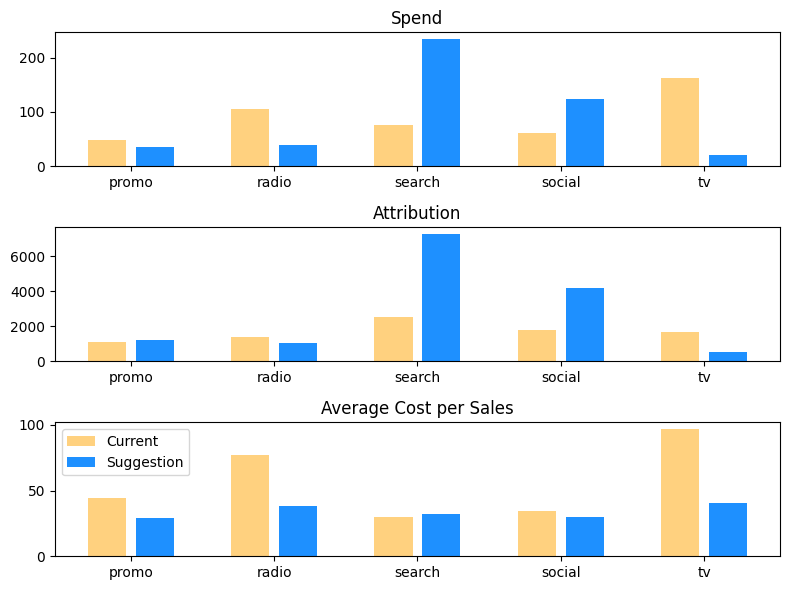

In [99]:
# TODO: figure out the y-axis unit

fig, ax = plt.subplots(3, 1, figsize=(8, 6))
# spend
ax[0].bar(
    x=np.arange(0, 3 * len(optim_channels), 3),
    height=cost_report["pre-opt-spend"],
    color="orange",
    alpha=0.5,
    label="Current",
)
ax[0].bar(
    x=np.arange(1, 3 * len(optim_channels) + 1, 3),
    height=cost_report["post-opt-spend"],
    color="dodgerblue",
    label="Suggestion",
)
ax[0].set_xticks(0.5 + np.arange(0, 3 * len(optim_channels), 3))
ax[0].set_xticklabels(optim_channels)
# ax[0].legend()
ax[0].set_title("Spend")

# Attribution
ax[1].bar(
    x=np.arange(0, 3 * len(optim_channels), 3),
    height=cost_report["pre-opt-attr"],
    color="orange",
    alpha=0.5,
    label="Current",
)
ax[1].bar(
    x=np.arange(1, 3 * len(optim_channels) + 1, 3),
    height=cost_report["post-opt-attr"],
    color="dodgerblue",
    label="Suggestion",
)
ax[1].set_xticks(0.5 + np.arange(0, 3 * len(optim_channels), 3))
ax[1].set_xticklabels(optim_channels)
# ax[1].legend()
ax[1].set_title("Attribution")

# Efficiency
ax[2].bar(
    x=np.arange(0, 3 * len(optim_channels), 3),
    height=cost_report["pre-opt-avg-cost"],
    color="orange",
    alpha=0.5,
    label="Current",
)
ax[2].bar(
    x=np.arange(1, 3 * len(optim_channels) + 1, 3),
    height=cost_report["post-opt-avg-cost"],
    color="dodgerblue",
    label="Suggestion",
)
ax[2].set_xticks(0.5 + np.arange(0, 3 * len(optim_channels), 3))
ax[2].set_xticklabels(optim_channels)
ax[2].legend()
ax[2].set_title("Average Cost per Sales")

fig.tight_layout()

### Outcome Plot

In [23]:
df = mmm.get_raw_df()
optim_pred = mmm.predict(optim_spend_df)
init_pred = mmm.predict(df)

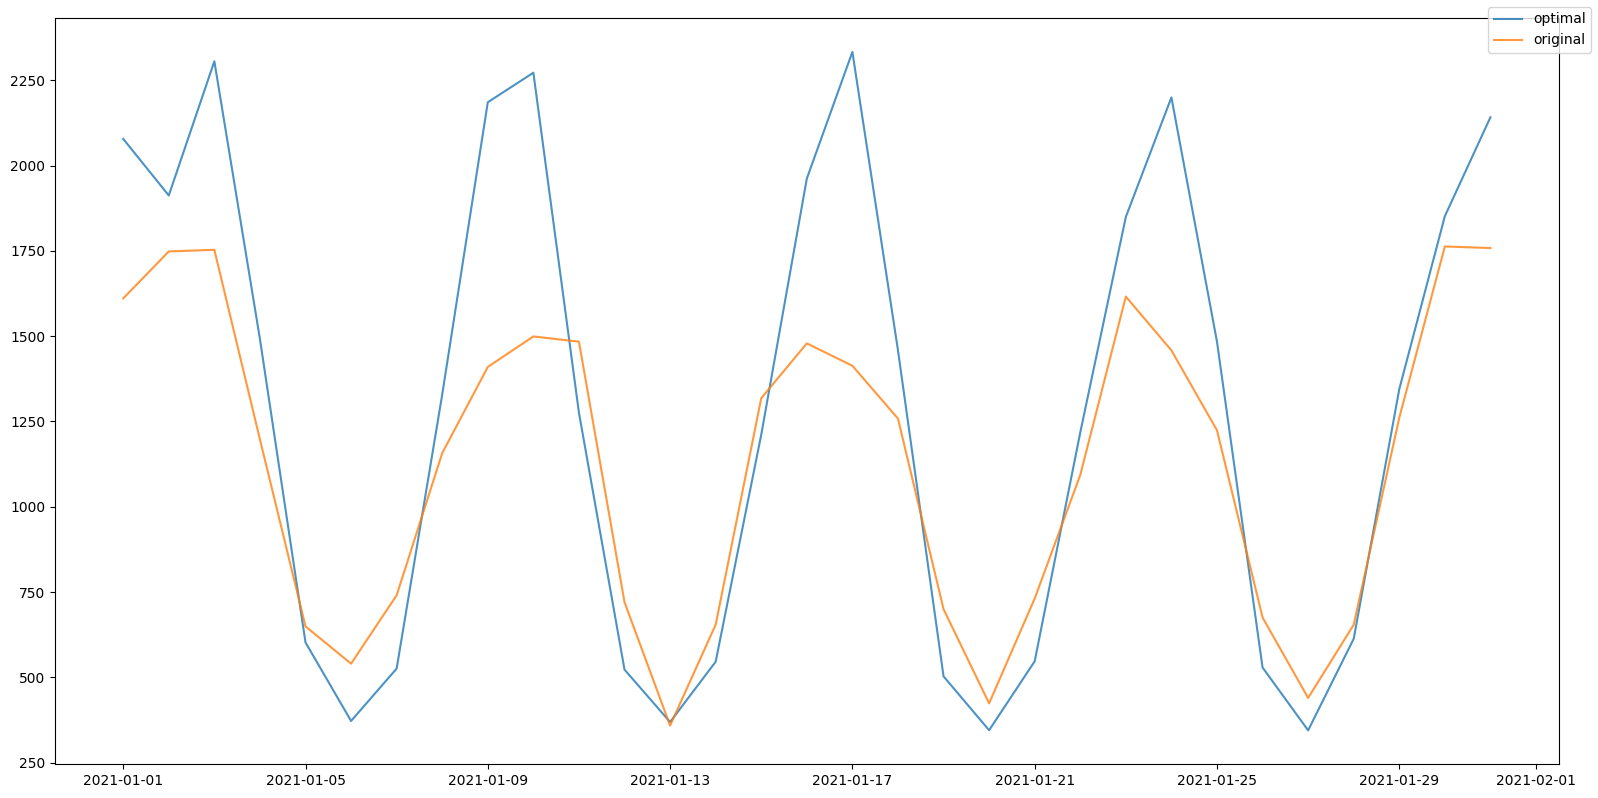

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
ax.plot(
    optim_pred.loc[maximizer.result_mask, "date"].values,
    optim_pred.loc[maximizer.result_mask, "prediction"].values,
    label="optimal",
    alpha=0.8,
)
ax.plot(
    init_pred.loc[maximizer.result_mask, "date"].values,
    init_pred.loc[maximizer.result_mask, "prediction"].values,
    label="original",
    alpha=0.8,
)
fig.legend()
fig.tight_layout();

In [14]:
# check2: total predicted response must be higher than current
total_optim_pred = np.sum(optim_pred.loc[maximizer.result_mask, "prediction"].values)
total_init_pred = np.sum(init_pred.loc[maximizer.result_mask, "prediction"].values)
assert total_optim_pred > total_init_pred

### Cost Curve

In [15]:
from karpiu.planning.cost_curves import CostCurves

In [16]:
cc = CostCurves(
    model=mmm,
    n_steps=10,
    curve_type="individual",
    extend_multiplier=1.05,
)
cc.generate_cost_curves()
cc_optim = CostCurves(
    model=mmm,
    n_steps=10,
    curve_type="individual",
    spend_df=optim_spend_df,
    extend_multiplier=1.05,
)
cc_optim.generate_cost_curves()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

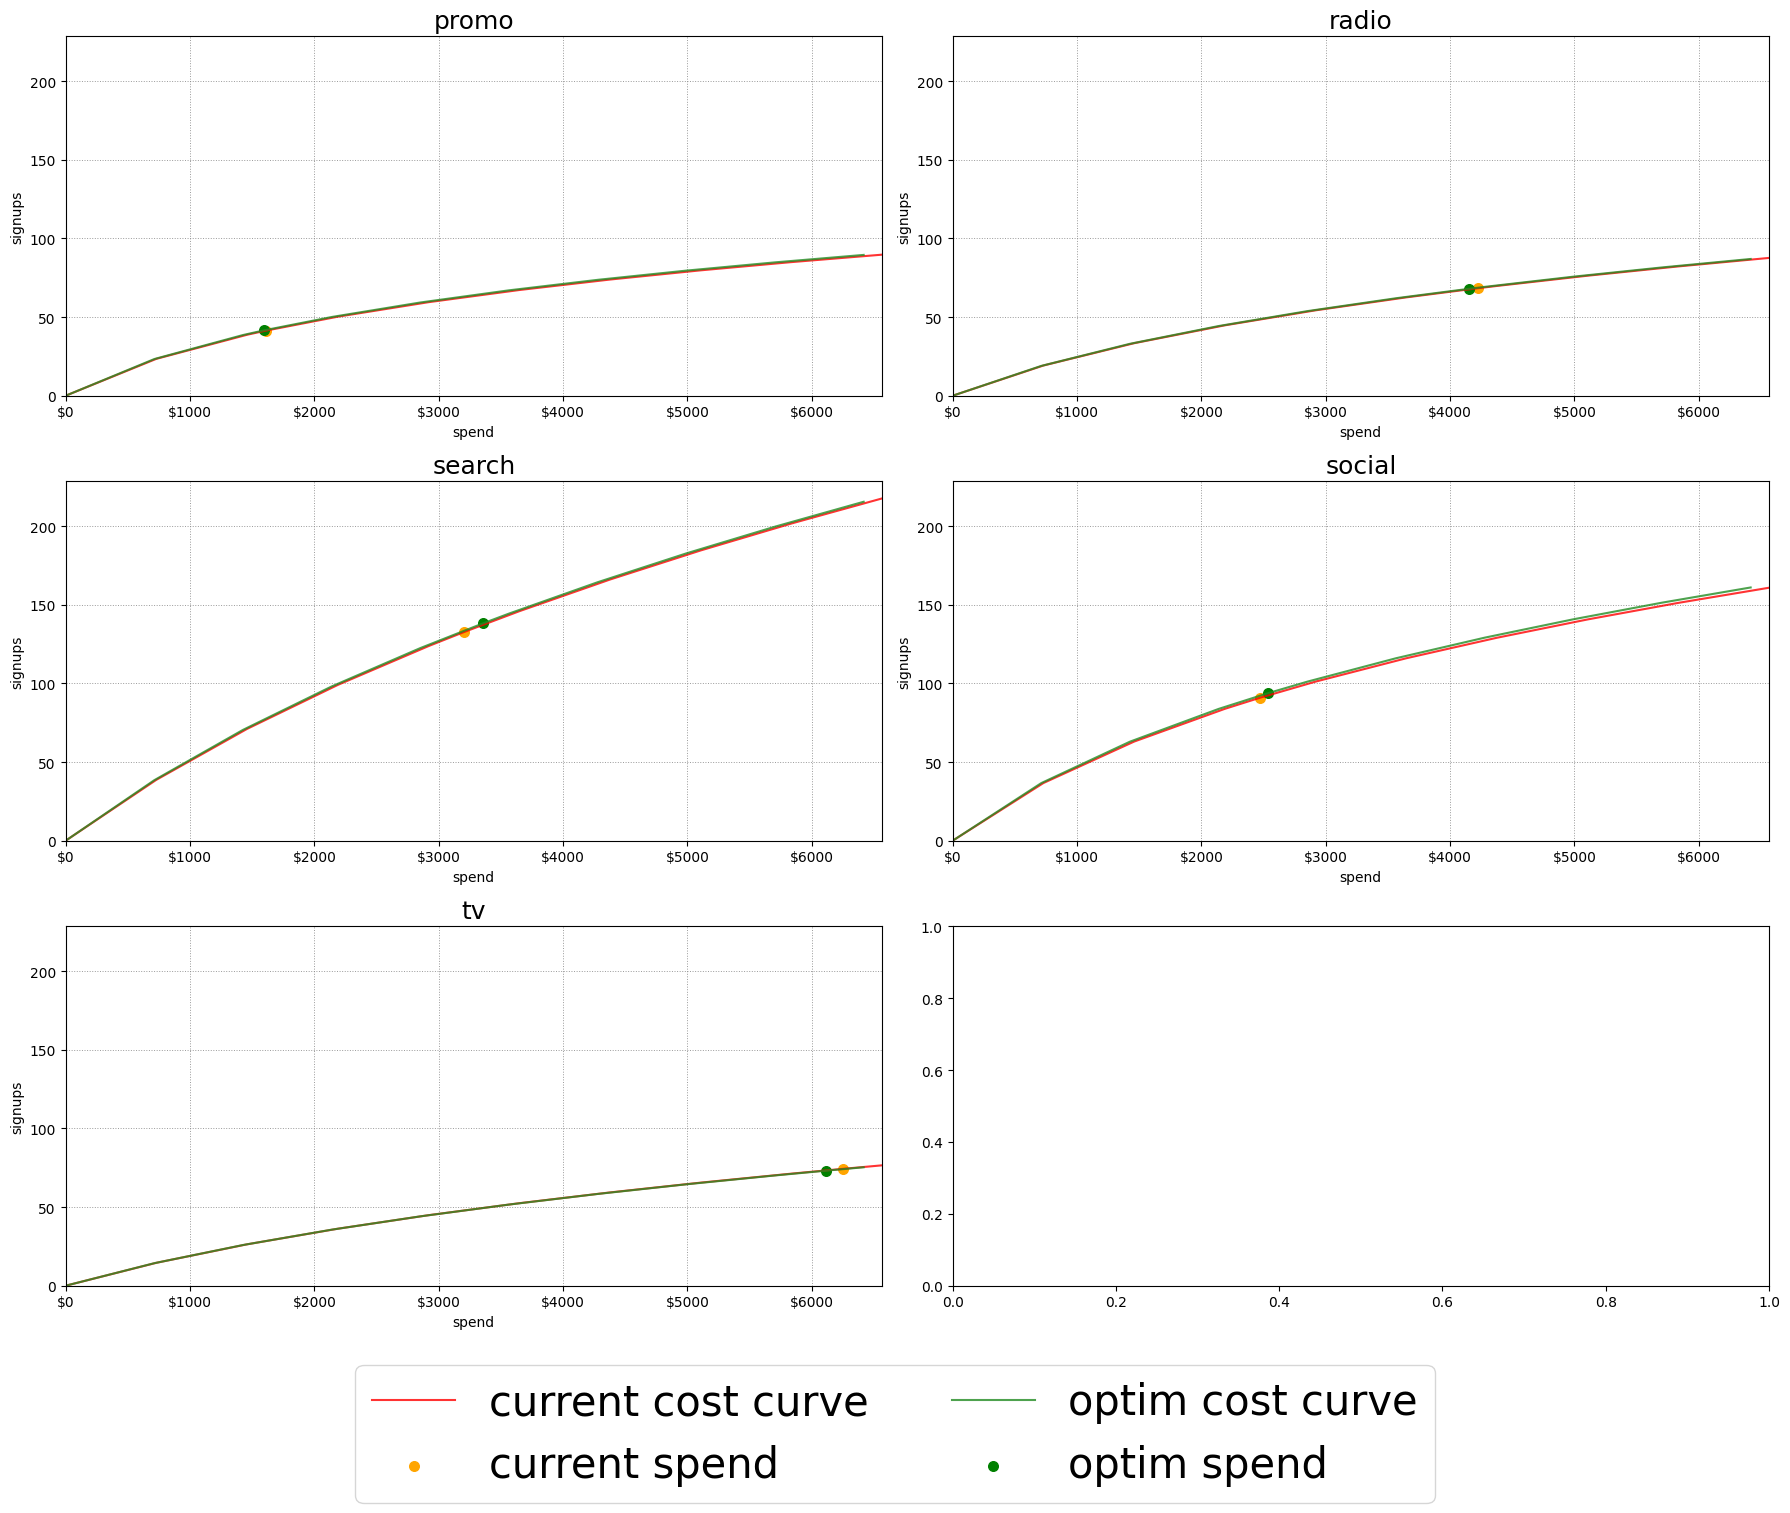

In [17]:
cc.plot(optim_cost_curves=cc_optim.cost_curves, include_organic=False);

In [18]:
xs = maximizer.get_callback_metrics()["xs"]
fig_paths = list()
idx_seq = np.round(np.linspace(0, len(xs) - 1, 10)).astype(int)
for idx in idx_seq:
    x = xs[idx]
    x = x.reshape(-1, maximizer.n_optim_channels) * maximizer.spend_scaler
    # build a temporary spend_df
    temp_df = mmm.get_raw_df()
    temp_df.loc[maximizer.budget_mask, optim_channels] = x

    cc = CostCurves(
        model=mmm,
        n_steps=10,
        curve_type="individual",
        extend_multiplier=1.05,
    )
    cc.generate_cost_curves()
    cc_optim = CostCurves(
        model=mmm,
        n_steps=10,
        curve_type="individual",
        spend_df=temp_df,
        extend_multiplier=1.05,
    )
    cc_optim.generate_cost_curves()
    axes = cc.plot(
        optim_cost_curves=cc_optim.cost_curves, include_organic=False, is_visible=False
    )
    fig = axes[0].get_figure
    fig = axes[0].get_figure()
    fig_path = "./demo_optim_output/png/fig_{:07d}.png".format(idx)
    fig_paths.append(fig_path)
    fig.savefig(fname=fig_path)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [19]:
# convert .png files to gif

import imageio

with imageio.get_writer(
    "./demo_optim_output/optim.gif", mode="I", duration=500
) as writer:
    for fig_path in fig_paths:
        image = imageio.imread(fig_path)
        writer.append_data(image)

/var/folders/g0/77v1jc9s455cj14mkqcht0m00000gn/T/ipykernel_68025/4182225652.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(fig_path)
